In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For the Dataset
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Taking the data 
print("Downloading 25 years of Gold Price Data...")
data = yf.download("GC=F", period="25y", interval="1d")
data.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Keep only necessary columns
df = data[['Date', 'Open', 'High', 'Low', 'Close']].copy()
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
print(df.head())

Price        Date        Open        High         Low       Close
Ticker                   GC=F        GC=F        GC=F        GC=F
0      2001-02-14  260.000000  260.000000  259.399994  259.399994
1      2001-02-15  259.500000  259.500000  255.100006  255.100006
2      2001-02-16  255.000000  258.500000  255.000000  258.200012
3      2001-02-20  256.100006  256.100006  255.000000  256.100006
4      2001-02-21  256.700012  258.200012  256.600006  258.200012


In [4]:
df.tail()

Price,Date,Open,High,Low,Close
Ticker,,GC=F,GC=F,GC=F,GC=F
6269,2026-02-09,5017.399902,5065.700195,4979.100098,5050.899902
6270,2026-02-10,5013.500000,5029.000000,5002.700195,5003.799805
6271,2026-02-11,5049.899902,5111.299805,5041.299805,5071.600098
6272,2026-02-12,5060.399902,5078.100098,4892.000000,4923.700195
6273,2026-02-13,4953.000000,5043.899902,4946.200195,5022.000000


In [5]:
# Flatten multi-level columns
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

In [6]:
df.head()

,Date,Open,High,Low,Close
0,2001-02-14,260.000000,260.000000,259.399994,259.399994
1,2001-02-15,259.500000,259.500000,255.100006,255.100006
2,2001-02-16,255.000000,258.500000,255.000000,258.200012
3,2001-02-20,256.100006,256.100006,255.000000,256.100006
4,2001-02-21,256.700012,258.200012,256.600006,258.200012


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6274 entries, 0 to 6273
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6274 non-null   datetime64[ns]
 1   Open    6274 non-null   float64       
 2   High    6274 non-null   float64       
 3   Low     6274 non-null   float64       
 4   Close   6274 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 245.2 KB


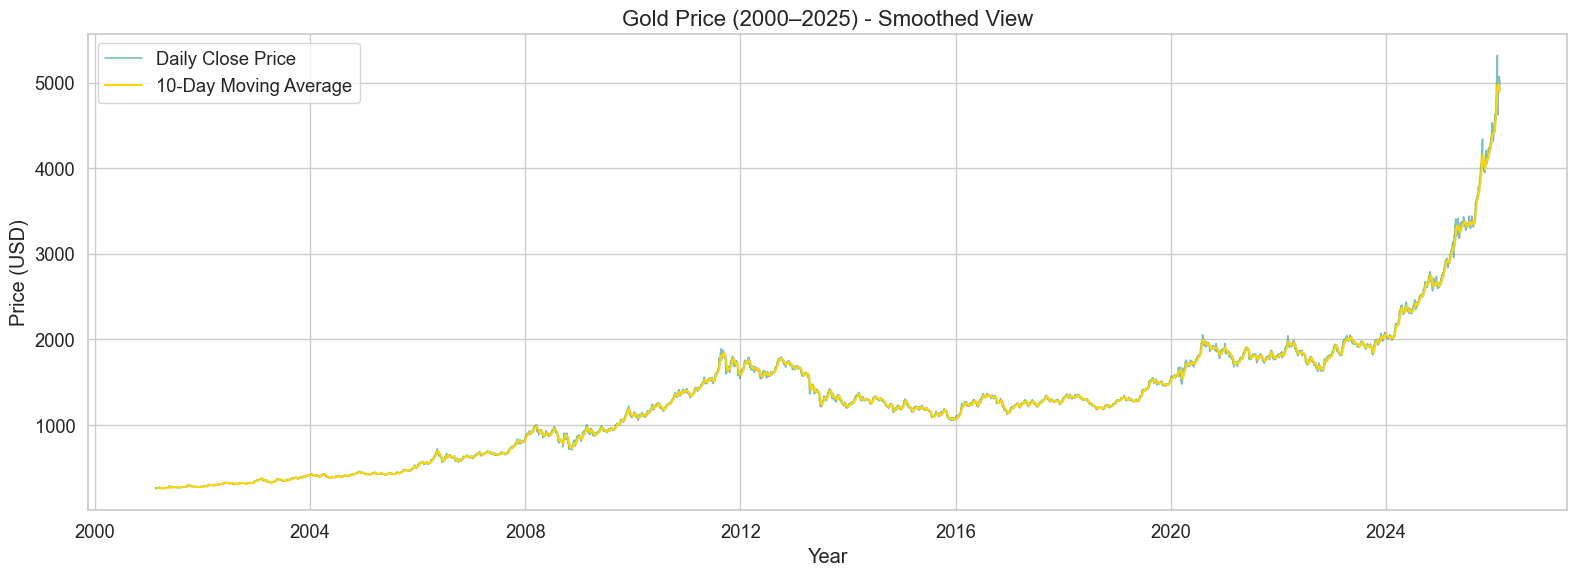

In [8]:
# Set visual style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)
# 10-day moving average for smoother trend
df['MA_10'] = df['Close'].rolling(window=10).mean()

plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'], color='teal', linewidth=1.2, label='Daily Close Price', alpha=0.5)
plt.plot(df['Date'], df['Close'].rolling(window=10).mean(), color='gold', linewidth=1.5, label='10-Day Moving Average') # df['MA_10'] is not working
plt.title('Gold Price (2000–2025) - Smoothed View', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

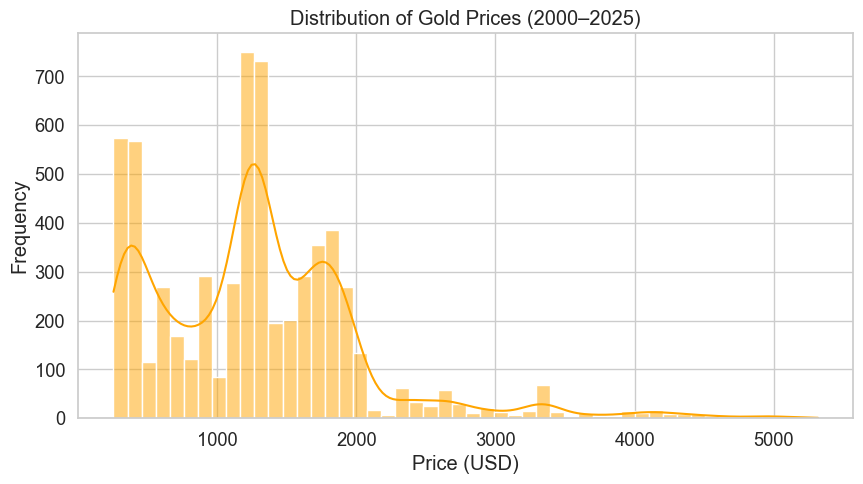

In [9]:
# What are the highest repeated values of Gold (USD)
plt.figure(figsize=(10, 5))
sns.histplot(df['Close'], bins=50, kde=True, color='orange')
plt.title('Distribution of Gold Prices (2000–2025)')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()

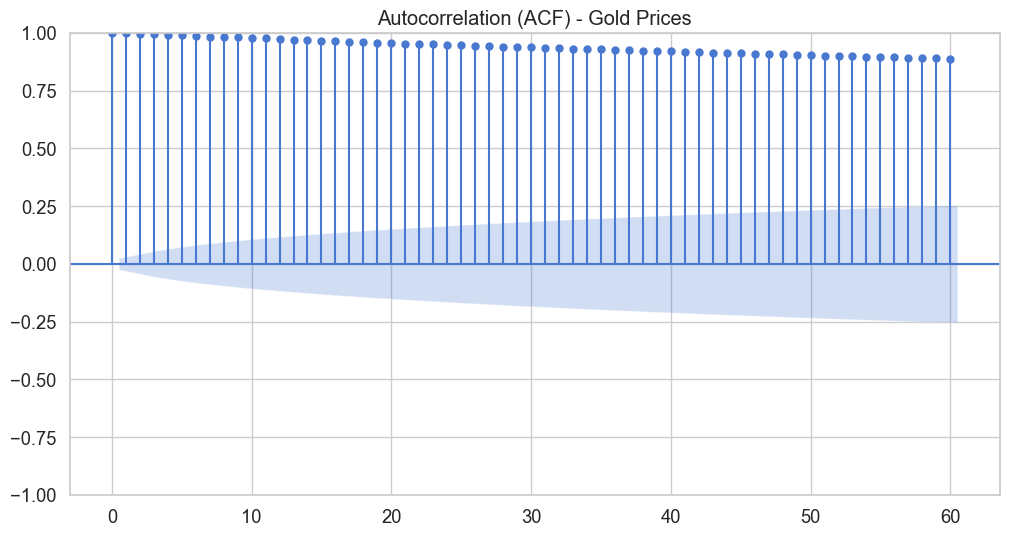

In [10]:
# Autocorrelation to check temporal dependence
plot_acf(df['Close'], lags=60)
plt.title('Autocorrelation (ACF) - Gold Prices')
plt.show()

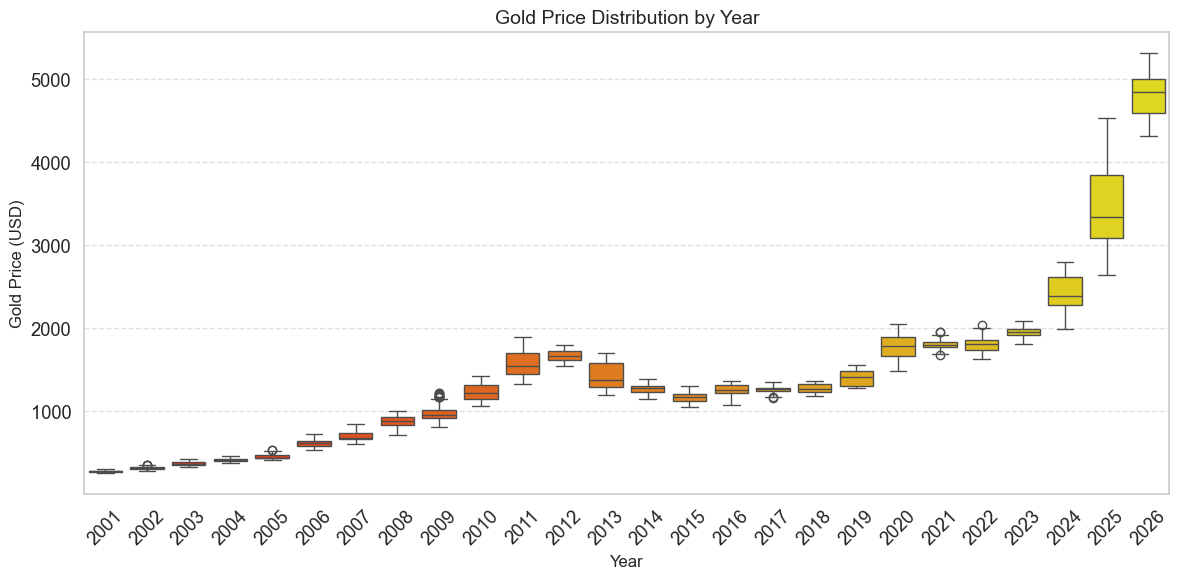

In [11]:
# Ensure Date is a datetime column (important for extracting Year)
df['Date'] = pd.to_datetime(df['Date'])
# Extract Year (if not already)
df['Year'] = df['Date'].dt.year
# Make sure 'Close' is 1D (not nested)
df['Close'] = df['Close'].astype(float)

# Boxplot by Year
plt.figure(figsize=(14, 6))
sns.boxplot(x='Year', y='Close', data=df, palette='autumn')
plt.title('Gold Price Distribution by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Gold Price (USD)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

In [12]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Scale the data (LSTM works best with normalized input)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close']])

# === Create sequences for LSTM ===
def create_sequences(data, window_size=100):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])   # 👈 all features now
        y.append(data[i, 3])              # 👈 predict “Close” (column index 3)
    return np.array(X), np.array(y)


window_size = 100  # use past 100 days to predict the next day
X, y = create_sequences(scaled_data, window_size)

# Split into train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4939, 100, 4)
X_test shape: (1235, 100, 4)
y_train shape: (4939,)
y_test shape: (1235,)


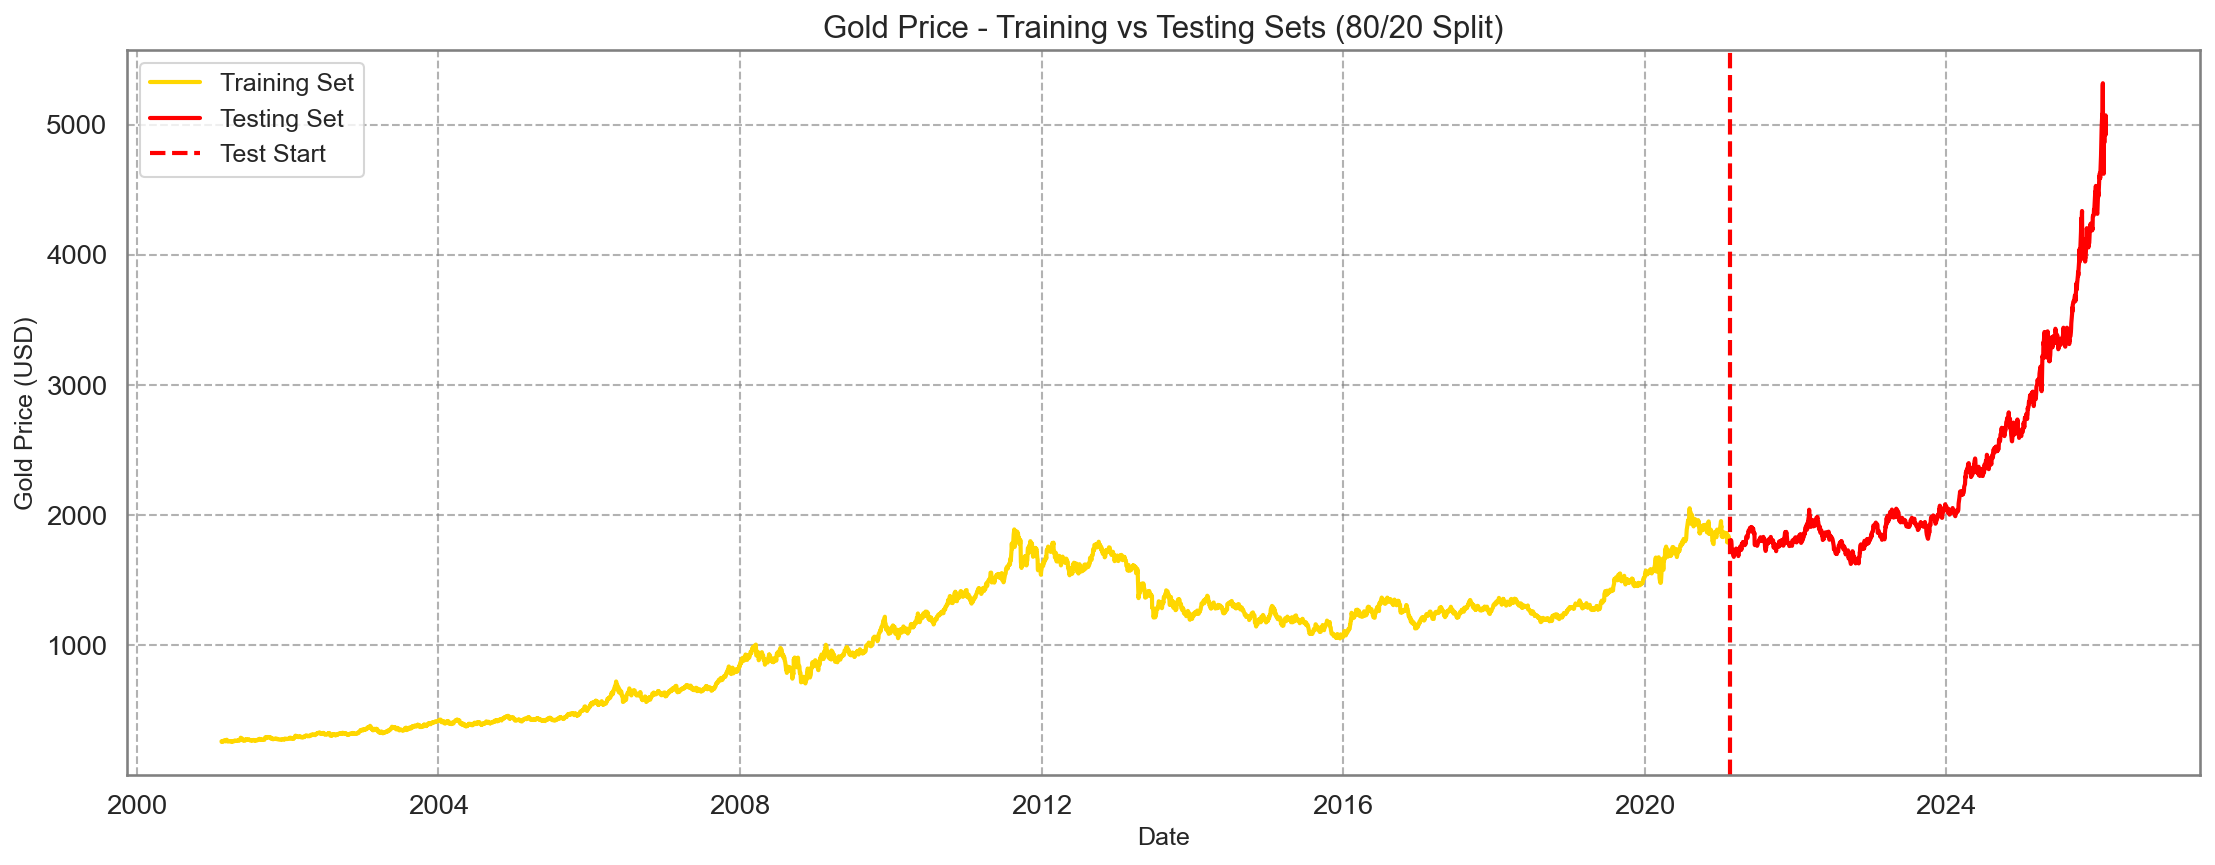

In [13]:
# ✅ Reset index to get 'Date' as a column
df_reset = df.reset_index()

# ✅ Get sizes from your split
train_size = int(len(df_reset) * 0.8)
test_size = len(df_reset) - train_size

# ✅ Plot Train vs Test Sets
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes', edgecolor='grey')

# Training Data (first 80%)
plt.plot(df_reset['Date'][:train_size], df_reset['Close'][:train_size],
         color='gold', lw=2, label='Training Set')

# Testing Data (last 20%)
plt.plot(df_reset['Date'][train_size:], df_reset['Close'][train_size:],
         color='red', lw=2, label='Testing Set')

# Add vertical line at the split point
plt.axvline(x=df_reset['Date'][train_size], color='red', linestyle='--', lw=2, label='Test Start')

plt.title('Gold Price - Training vs Testing Sets (80/20 Split)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Gold Price (USD)', fontsize=12)
plt.legend(loc='upper left', prop={'size': 12})
plt.grid(color='grey', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [14]:
# Define model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.4790e-04 - val_loss: 7.2266e-04
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 2.3773e-05 - val_loss: 5.4027e-04
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 2.3113e-05 - val_loss: 6.9030e-04
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2.1740e-05 - val_loss: 5.7913e-04
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 2.0524e-05 - val_loss: 5.0192e-04
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2.1789e-05 - val_loss: 3.9380e-04
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.0195e-05 - val_loss: 3.3465e-04
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.8463e-05 - val_loss: 4.1663e-04
Epoch 9/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1.9447e-05 - val_loss: 2.6800e-04
Epoch 10/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.7456e-05 - val_loss: 3.2900e-04
Epoch 11/100
155/155 ━━━━━━━━━━━━━━━━━━

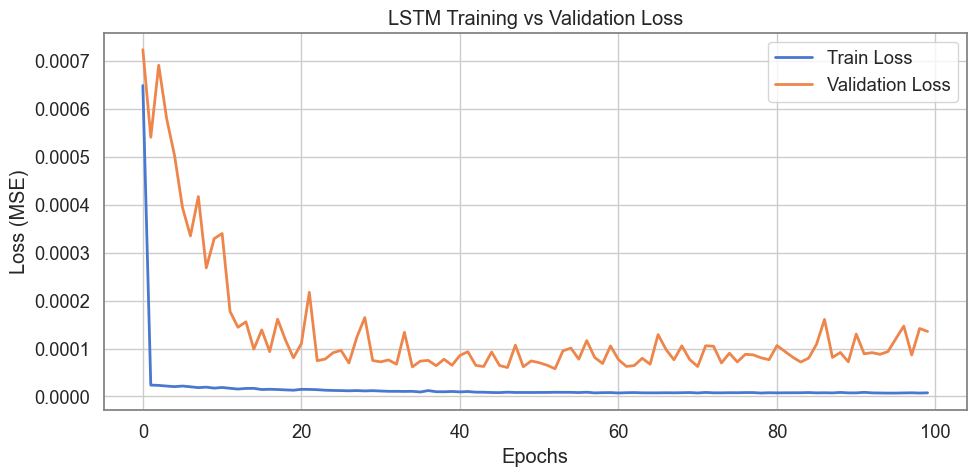

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('LSTM Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Evaluate test loss (MSE)
result = model.evaluate(X_test, y_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3555e-04


In [17]:
# Predict
y_pred = model.predict(X_test)

# Calculate MAPE and Accuracy
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("📊 Model Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
📊 Model Evaluation Metrics:
MAE  (Mean Absolute Error): 0.0072
RMSE (Root Mean Squared Error): 0.0116
R² Score: 0.9942
Test Loss: 0.00013555141049437225
Test MAPE: 0.014820350678927972
Test Accuracy: 0.985179649321072


In [18]:
print("\n--- SECTION 11: SAVING FINAL MODEL AND PREPROCESSOR ---")

import pickle

# --- 1️⃣ Save the trained LSTM model ---
model.save("gold_price_lstm_model.keras")
print("--- LSTM model successfully saved to 'gold_price_lstm_model.keras' ---")

# --- 2️⃣ Save the fitted MinMaxScaler ---
with open("gold_price_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("--- Scaler successfully saved to 'gold_price_scaler.pkl' ---")

print("\n✅ Model and preprocessor saved successfully. Ready for future predictions!")


--- SECTION 11: SAVING FINAL MODEL AND PREPROCESSOR ---
--- LSTM model successfully saved to 'gold_price_lstm_model.keras' ---
--- Scaler successfully saved to 'gold_price_scaler.pkl' ---

✅ Model and preprocessor saved successfully. Ready for future predictions!
